In [ ]:
'''
3. Machine Translation with Transformer (EN→FR) 
Dataset: Subset of English-French sentence pairs (e.g., Tatoeba, IWSLT) 
Goal: Build a transformer encoder-decoder from scratch. 
Key tasks: 
 Implement both encoder and decoder blocks 
 Teacher forcing during training 
 Evaluate using BLEU score
'''

In [24]:
# Transformer-based EN → FR Translation

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datasets import load_dataset
import matplotlib.pyplot as plt

In [25]:
# 1. Load and sample dataset
data = load_dataset("iwslt2017", "iwslt2017-en-fr", trust_remote_code=True)
train_data = data['train'].shuffle(seed=42).select(range(2000))

eng_texts = [x['translation']['en'] for x in train_data]
fra_texts = ['<start> ' + x['translation']['fr'] + ' <end>' for x in train_data]

# 2. Tokenize and pad
eng_tokenizer = Tokenizer(filters='', oov_token='<unk>')
fra_tokenizer = Tokenizer(filters='', oov_token='<unk>')
eng_tokenizer.fit_on_texts(eng_texts)
fra_tokenizer.fit_on_texts(fra_texts)

eng_seq = eng_tokenizer.texts_to_sequences(eng_texts)
fra_seq = fra_tokenizer.texts_to_sequences(fra_texts)

maxlen_en = max(len(seq) for seq in eng_seq)
maxlen_fr = max(len(seq) for seq in fra_seq)

X_en = pad_sequences(eng_seq, maxlen=maxlen_en, padding='post')
X_fr_in = pad_sequences([s[:-1] for s in fra_seq], maxlen=maxlen_fr-1, padding='post')
X_fr_out = pad_sequences([s[1:] for s in fra_seq], maxlen=maxlen_fr-1, padding='post')

In [26]:
# 3. Positional Encoding
def positional_encoding(max_len, d_model):
    pos = np.arange(max_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / d_model)
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.cast(angle_rads, dtype=tf.float32)


In [27]:
# 4. Define model
vocab_en = len(eng_tokenizer.word_index) + 1
vocab_fr = len(fra_tokenizer.word_index) + 1
d_model = 128

def create_padding_mask(seq):
    mask = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return mask[:, tf.newaxis, tf.newaxis, :]

enc_inputs = Input(shape=(maxlen_en,), name="encoder_inputs")
dec_inputs = Input(shape=(maxlen_fr-1,), name="decoder_inputs")

enc_mask = Lambda(create_padding_mask)(enc_inputs)

enc_emb = Embedding(vocab_en, d_model, mask_zero=True)(enc_inputs)
enc_emb += positional_encoding(maxlen_en, d_model)

enc_attn = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=d_model)
enc_out = enc_attn(enc_emb, enc_emb, attention_mask=enc_mask)
enc_out = LayerNormalization()(enc_emb + enc_out)

ffn = Dense(512, activation='relu')(enc_out)
enc_out = LayerNormalization()(enc_out + Dense(d_model)(ffn))

# Decoder
look_ahead_mask = Lambda(lambda x: 1 - tf.linalg.band_part(tf.ones((maxlen_fr-1, maxlen_fr-1)), -1, 0))(dec_inputs)
dec_emb = Embedding(vocab_fr, d_model, mask_zero=True)(dec_inputs)
dec_emb += positional_encoding(maxlen_fr-1, d_model)

dec_attn1 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=d_model)
out1 = dec_attn1(dec_emb, dec_emb, attention_mask=look_ahead_mask)
out1 = LayerNormalization()(dec_emb + out1)

dec_attn2 = tf.keras.layers.MultiHeadAttention(num_heads=4, key_dim=d_model)
out2 = dec_attn2(out1, enc_out, enc_out, attention_mask=enc_mask)
out2 = LayerNormalization()(out1 + out2)

ffn_dec = Dense(512, activation='relu')(out2)
ffn_dec = Dense(d_model)(ffn_dec)
dec_out = LayerNormalization()(out2 + ffn_dec)

final_out = Dense(vocab_fr)(dec_out)
model = Model(inputs=[enc_inputs, dec_inputs], outputs=final_out)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs (InputLayer)   │ (None, 75)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_9 (Embedding)       │ (None, 75, 128)           │         971,520 │ encoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_19 (Add)                  │ (None, 75, 128)           │               0 │ embedding_9[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_4 (Lambda)             │ (None, 1, 1, 75)          │               0 │ encoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_10       │ (None, 75, 128)           │         263,808 │ add_19[0][0],              │
│ (MultiHeadAttention)          │                           │                 │ add_19[0][0],              │
│                               │                           │                 │ lambda_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_inputs (InputLayer)   │ (None, 82)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_20 (Add)                  │ (None, 75, 128)           │               0 │ add_19[0][0],              │
│                               │                           │                 │ multi_head_attention_10[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_10 (Embedding)      │ (None, 82, 128)           │       1,142,400 │ decoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_14        │ (None, 75, 128)           │             256 │ add_20[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_22 (Add)                  │ (None, 82, 128)           │               0 │ embedding_10[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lambda_5 (Lambda)             │ (82, 82)                  │               0 │ decoder_inputs[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 75, 512)           │          66,048 │ layer_normalization_14[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_11       │ (None, 82, 128)           │         263,808 │ add_22[0][0],              │
│ (MultiHeadAttention)          │                           │                 │ add_22[0][0],              │
│                               │                           │                 │ lambda_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 75, 128)           │          65,664 │ dense_14[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 4,321,373 (16.48 MB)

 Trainable params: 4,321,373 (16.48 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 558ms/step - loss: 5.7183 - val_loss: 2.1008
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 509ms/step - loss: 2.0372 - val_loss: 1.6146
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 524ms/step - loss: 1.6147 - val_loss: 1.5749
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 494ms/step - loss: 1.6068 - val_loss: 1.5757
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 491ms/step - loss: 1.5678 - val_loss: 1.5164
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 32s 569ms/step - loss: 1.4098 - val_loss: 1.3782
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 33s 587ms/step - loss: 1.2492 - val_loss: 1.1990
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 524ms/step - loss: 1.0503 - val_loss: 0.9890
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 29s 504ms/step - loss: 0.8761 - val_loss: 0.8906
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 498ms/step - loss: 0.7010 - val_loss: 0.8088


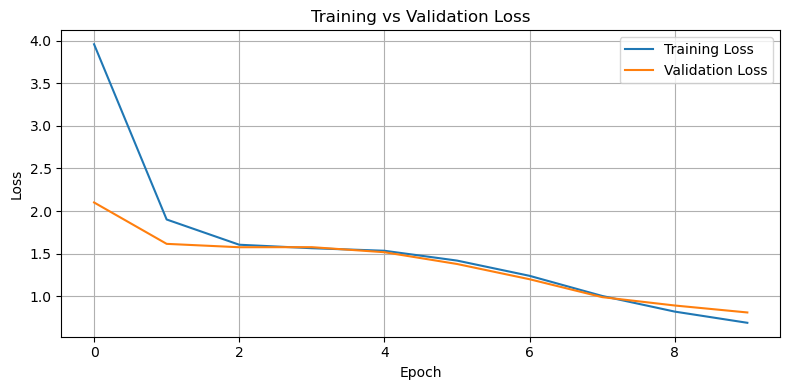

In [28]:
# 5. Train
history = model.fit([X_en, X_fr_in], X_fr_out, epochs=10, batch_size=32, validation_split=0.1)

# 6. Visualization of training
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
